<a href="https://colab.research.google.com/github/rsaketh002/emotions/blob/main/emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

In [4]:
data=load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification

In [7]:
checkpoint='xlm-roberta-base'

In [8]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [9]:
def preprocess_fn(ans):
    return tokenizer(ans['text'],truncation=True)

In [10]:
tokenized_data=data.map(preprocess_fn,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
set(data['train']['label'])

{0, 1, 2, 3, 4, 5}

In [12]:
num_labels=6

In [13]:
id2label={0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}
label2id={v:k for k,v in id2label.items()}

In [14]:
label2id

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [15]:
model=TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=6,id2label=id2label,label2id=label2id)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import tensorflow as tf

In [17]:
model.summary()

Model: "tfxlm_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainL  multiple                  277453056 
 ayer)                                                           
                                                                 
 classifier (TFXLMRobertaCl  multiple                  595206    
 assificationHead)                                               
                                                                 
Total params: 278048262 (1.04 GB)
Trainable params: 278048262 (1.04 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
from transformers import DataCollatorWithPadding

In [19]:
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

In [20]:
tokenized_data=tokenized_data.remove_columns('text')

In [22]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_data["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [23]:
from sklearn.metrics import accuracy_score,f1_score

In [24]:
def compute_metrics(eval_pred):
  predictions,labels=eval_pred
  predictions=tf.nn.softmax(predictions,axis=1)
  predictions=np.argmax(predictions,axis=1)
  f1 = f1_score(labels, predictions, average='weighted')
  accuracy = accuracy_score(labels, predictions)
  metrics = {'f1_score': f1, 'accuracy': accuracy}
  return metrics

In [30]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [31]:
model.compile(optimizer=optimizer)

In [32]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [33]:
callbacks = [metric_callback]

In [34]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
1000/1000 [==============================] - 296s 248ms/step - loss: 0.7572 - val_loss: 0.2379 - f1_score: 0.9158 - accuracy: 0.9150
Epoch 2/3
1000/1000 [==============================] - 239s 240ms/step - loss: 0.1999 - val_loss: 0.1670 - f1_score: 0.9321 - accuracy: 0.9325
Epoch 3/3
1000/1000 [==============================] - 242s 242ms/step - loss: 0.1349 - val_loss: 0.1642 - f1_score: 0.9329 - accuracy: 0.9325


In [62]:
text=data['validation']['text']
labels=data['validation']['label']


In [66]:
text_pre=data['validation'].map(preprocess_fn,batched=False)
text_pre.remove_columns(['text','label'])
X=model.prepare_tf_dataset(
    tokenized_data["validation"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator,
)

In [67]:
X

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [57]:
from sklearn.metrics import confusion_matrix

In [68]:
pred=model.predict(X)

2000/2000 [==============================] - 65s 30ms/step


In [70]:
predictions=tf.nn.softmax(pred['logits'],axis=1)

In [72]:
predictions=np.argmax(predictions,axis=1)

In [74]:
set(predictions)

{0, 1, 2, 3, 4, 5}

In [76]:
cm=confusion_matrix(labels,predictions)

In [77]:
import seaborn as sns

<Axes: >

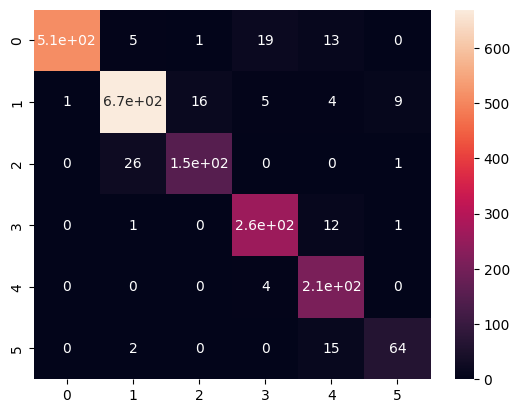

In [78]:
sns.heatmap(cm,annot=True)

In [79]:
from sklearn.metrics import classification_report

In [80]:
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       550
           1       0.95      0.95      0.95       704
           2       0.90      0.85      0.87       178
           3       0.90      0.95      0.93       275
           4       0.83      0.98      0.90       212
           5       0.85      0.79      0.82        81

    accuracy                           0.93      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.94      0.93      0.93      2000

